<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020/blob/main/mnist_mlp_minimal_hyperopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

batch_size = 128
num_classes = 10
epochs = 10 #20

N_TRAIN_EXAMPLES = 3000
N_TEST_EXAMPLES = 1000

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# print info about a shape of arrays
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')
print(y_train.shape, 'train samples')
print(y_test.shape, 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# take a subset of all MNIST events
x_train = x_train[:N_TRAIN_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]
x_test = x_test[:N_TEST_EXAMPLES]
y_test = y_test[:N_TEST_EXAMPLES]

# print info about a shape of arrays
print(x_train.shape, 'train samples after conversion')
print(x_test.shape, 'test samples  after conversion')
print(y_train.shape, 'train samples after conversion')
print(y_test.shape, 'test samples  after conversion')


(60000, 784) train samples
(10000, 784) test samples
(60000,) train samples
(10000,) test samples
(3000, 784) train samples after conversion
(1000, 784) test samples  after conversion
(3000, 10) train samples after conversion
(1000, 10) test samples  after conversion


In [2]:
space = {

            'units1': hp.quniform('units1', 32,3*1024,1),
            'dropout1': hp.uniform('dropout1', .00,.50),

        }

In [3]:
def f_nn(params):   

    #print ('Parameters testing: ', params)

    model = Sequential()
    model.add(Dense(int(params['units1']), activation='relu', input_shape=(784,)))
    model.add(Dropout(params['dropout1']))
    model.add(Dense(int(params['units1']), activation='relu'))
    model.add(Dropout(params['dropout1']))
    model.add(Dense(int(params['units1']), activation='relu'))
    model.add(Dropout(params['dropout1']))
    model.add(Dense(num_classes, activation='softmax'))

    #model.summary()

    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))
    
    score = model.evaluate(x_test, y_test, verbose=0)
    #print('Test accuracy:', score[1])

    return {'loss': -score[1], 'status': STATUS_OK}



# **Find the best parameters:**

In [4]:

trials = Trials()
best = fmin(fn=f_nn, space=space, algo=tpe.suggest, max_evals=50, trials=trials)



100%|██████████| 50/50 [02:02<00:00,  2.44s/it, best loss: -0.9340000152587891]


In [5]:
print('best: ', best)
print('best accuracy: ',-trials.best_trial['result']['loss'])

#from hyperopt import space_eval
#print('best parameters: ',space_eval(space, best))

best:  {'dropout1': 0.05698266079745175, 'units1': 2283.0}
best accuracy:  0.9340000152587891


# **Visualization**

In [6]:
print(trials.trials)

[{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -0.921999990940094, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'dropout1': [0], 'units1': [0]}, 'vals': {'dropout1': [0.21956443660322156], 'units1': [1983.0]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 12, 2, 20, 58, 37, 468000), 'refresh_time': datetime.datetime(2020, 12, 2, 20, 58, 41, 321000)}, {'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': -0.8920000195503235, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'dropout1': [1], 'units1': [1]}, 'vals': {'dropout1': [0.1478254949398069], 'units1': [1314.0]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 12, 2, 20, 58, 41, 324000), 'refresh_time': datetime.datetime(2020, 12, 2, 20, 58, 43, 236000)}, {'state': 2, 'tid': 2, 'spec': None, 'result': {'loss': -0.92400002

avg best error: -0.9340000152587891


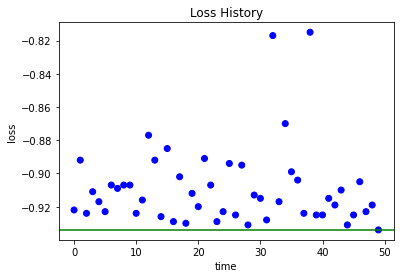

In [7]:
from hyperopt import plotting

plotting.main_plot_history(trials)

Showing Histogram of 50 jobs


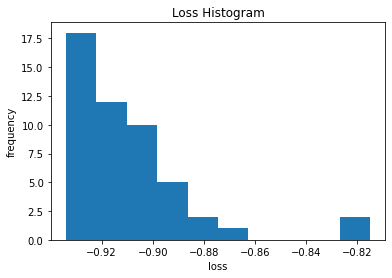

In [8]:
plotting.main_plot_histogram(trials)

finite loss range -0.9340000152587891 -0.8149999976158142 -1.934000015258789


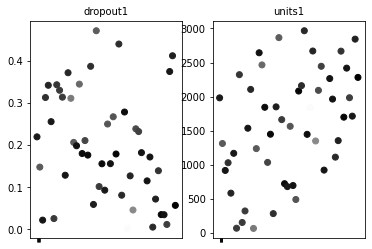

In [9]:
plotting.main_plot_vars(trials)

Text(0, 0.5, '$units$')

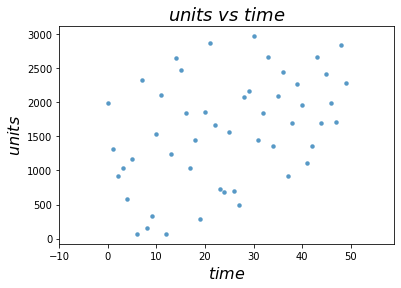

In [10]:
#units vs time

f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['units1'] for t in trials.trials]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$units$ $vs$ $time$ ', fontsize=18)
ax.set_xlabel('$time$', fontsize=16)
ax.set_ylabel('$units$', fontsize=16)

Text(0, 0.5, '$dropout$')

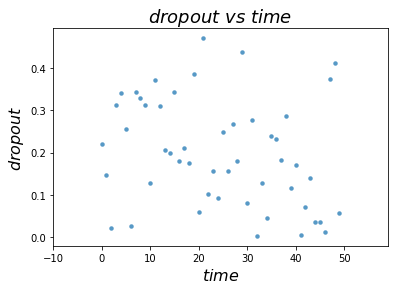

In [11]:
#units vs time

f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['dropout1'] for t in trials.trials]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$dropout$ $vs$ $time$ ', fontsize=18)
ax.set_xlabel('$time$', fontsize=16)
ax.set_ylabel('$dropout$', fontsize=16)

Text(0, 0.5, '$dropout$')

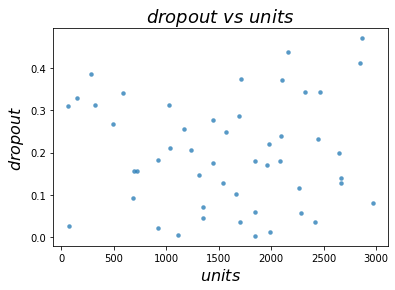

In [12]:
#dropout vs units

f, ax = plt.subplots(1)
xs = [t['misc']['vals']['units1'] for t in trials.trials]
ys = [t['misc']['vals']['dropout1'] for t in trials.trials]
#ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$dropout$ $vs$ $units$ ', fontsize=18)
ax.set_xlabel('$units$', fontsize=16)
ax.set_ylabel('$dropout$', fontsize=16)

Text(0, 0.5, '$accuracy$')

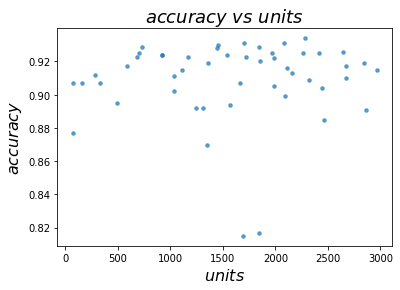

In [13]:
#value vs units

f, ax = plt.subplots(1)
xs = [t['misc']['vals']['units1'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
#ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$accuracy$ $vs$ $units$ ', fontsize=18)
ax.set_xlabel('$units$', fontsize=16)
ax.set_ylabel('$accuracy$', fontsize=16)



Text(0, 0.5, '$accuracy$')

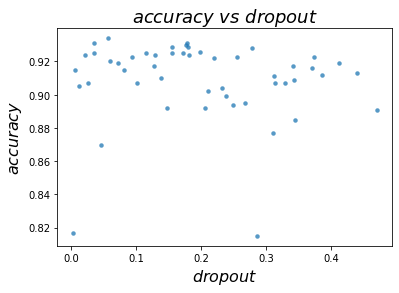

In [14]:
#value vs dropout

f, ax = plt.subplots(1)
xs = [t['misc']['vals']['dropout1'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
#ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$accuracy$ $vs$ $dropout$ ', fontsize=18)
ax.set_xlabel('$dropout$', fontsize=16)
ax.set_ylabel('$accuracy$', fontsize=16)

